# Base Models

In [1]:
# https://wandb.ai/kilianovski/misha-iml/runs/87g1uy6b?nw=nwuserkilianovski

checkpoint_path = '../models/transformers/grokking_prod_120_6_0.1_attnonly_False20240711_151833.pt'

transformer_config = dict(
    d_vocab=512,
    n_layers=6,
    d_model=1024,
    d_head=256,
    n_heads=4,
    d_mlp=512,
    n_ctx=5,
    act_fn="relu",  # gelu?
    normalization_type="LN",
    attn_only=False,
)

In [2]:
# ! pip install torch --upgrade

In [3]:
# # https://wandb.ai/kilianovski/misha-iml/runs/4xnrqoxv/logs
# checkpoint_path = '../models/transformers/grokking_prod_120_2_0.1_attnonly_True20240709_180213.pt'

# transformer_config = dict(
#     d_vocab=512,
#     n_layers=2,
#     d_model=2**7,
#     d_head=2**7,
#     n_heads=4,
#     d_mlp=2**8,
#     n_ctx=5,
#     act_fn="relu",  # gelu?
#     normalization_type="LN",
#     attn_only=True,
# )

In [4]:
# # https://wandb.ai/kilianovski/misha-iml/runs/vn9qak0w?nw=nwuserkilianovski

# STAGE 1 CKPT
checkpoint_path = '../models/transformers/stage1__grokking_prod_120_1_0.1_attnonly_False20240712_133838.pt'

transformer_config = dict(
    d_vocab=512,
    n_layers=1,
    d_model=1024,
    d_head=128,
    n_heads=4,
    d_mlp=256,
    n_ctx=5,
    act_fn="relu",  # gelu?
    normalization_type="LN",
    attn_only=False,
)

# Setup

In [5]:
import sys
sys.path.append('..')

In [6]:
from data import create_datasets, seed_all, DataParams, Tokens, OOCL_Dataset, make_tbl_mask, create_orig_data, yield_data

In [7]:
import logging
import torch
from dataclasses import dataclass, asdict
import numpy as np
import time
import os
from tqdm.auto import tqdm
from pathlib import Path
import itertools
import sys
import random
import torch.nn.functional as F
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import argparse
from transformer_lens import HookedTransformer, HookedTransformerConfig
import wandb
from dotenv import load_dotenv
from sympy import factorint
from itertools import product
from math import prod

import os
import random
import numpy as np
import torch
from tqdm.auto import tqdm

In [8]:
import lovely_tensors as lt
lt.monkey_patch()

In [9]:
import plotly.graph_objects as go
import numpy as np

def plot_probs(logits):
    
    # Create a sample one-dimensional tensor of probabilities
    probabilities = F.softmax(logits.detach(), dim=0).numpy()
    
    # Create labels for each probability (you can customize these)
    labels = [f'{i}' for i in range(len(probabilities))]
    
    # Create the bar chart
    fig = go.Figure(data=[
        go.Bar(x=labels, y=probabilities)
    ])
    
    # Update the layout
    fig.update_layout(
        title='Probability Distribution',
        xaxis_title='Token ID',
        yaxis_title='Probability',
        yaxis_range=[0, 1]  # Set y-axis range from 0 to 1 for probabilities
    )
    
    # Show the plot
    fig.show()

In [10]:
import plotly.graph_objects as go
import numpy as np
from torch.nn.functional import softmax

def plot_probs_with_slider(logits_list):
    # Convert logits to probabilities
    probabilities_list = [softmax(torch.tensor(logits), dim=0).numpy() for logits in logits_list]
    
    # Create labels for each probability
    labels = [f'{i}' for i in range(len(probabilities_list[0]))]
    
    # Create the initial bar chart
    fig = go.Figure(
        data=[go.Bar(x=labels, y=probabilities_list[0])],
        layout=go.Layout(
            title='Probability Distribution',
            xaxis_title='Token ID',
            yaxis_title='Probability',
            yaxis_range=[0, 1]
        )
    )
    
    # Add slider
    steps = []
    for i in range(len(logits_list)):
        step = dict(
            method="update",
            args=[{"y": [probabilities_list[i]]}],
            label=f"Step {i}"
        )
        steps.append(step)

    sliders = [dict(
        active=0,
        currentvalue={"prefix": "Step: "},
        pad={"t": 50},
        steps=steps
    )]
    
    fig.update_layout(sliders=sliders)
    
    # Show the plot
    fig.show()

# # Example usage:
# import torch

# # Create a list of sample logits
# logits_list = [
#     torch.randn(10) for _ in range(5)  # 5 sets of logits, each with 10 values
# ]



In [11]:

def get_device():
    #return 'cpu'
    if torch.cuda.is_available():
        return "cuda"
    # elif torch.backends.mps.is_available():
    #     return "mps"
    else:
        return "cpu"
        

In [12]:

def loss_fn(logits, tokens):

    # check whether question or def and compute loss appropriately
    # logit shape: [batch, pos, vocab]
    # token shape: [batch, pos]

    mask = (tokens[:, 3] == 2*DataParams.mod + Tokens.padding)

    def_logits = logits[mask]
    def_tokens = tokens[mask].long()

    q_logits = logits[~mask]
    q_tokens = tokens[~mask].long()

    def_logits = def_logits[:, 1].unsqueeze(1)
    def_tokens = def_tokens[:, 2].unsqueeze(1)
    def_log_probs = def_logits.log_softmax(-1)
    def_correct_log_probs = def_log_probs.gather(-1, def_tokens[..., None])[..., 0]
    
    q_logits = q_logits[:, 2].unsqueeze(1)
    q_tokens = q_tokens[:, 3].unsqueeze(1)
    q_log_probs = q_logits.log_softmax(-1)
    q_correct_log_probs = q_log_probs.gather(-1, q_tokens[..., None])[..., 0]

    return -(def_correct_log_probs.sum() + q_correct_log_probs.sum())/(def_correct_log_probs.shape[0] + q_correct_log_probs.shape[0])


In [13]:
def evaluate(model, val_loader, device):

    correct = 0
    loss = 0.
    total = 0
    batches = 0

    for batch in val_loader:
        inputs = batch[0].to(device)

        labels = inputs[:, -1]

        with torch.no_grad():
            output = model(inputs)
            loss += loss_fn(output, inputs).item()
            correct += (torch.argmax(output[:, -2, :], dim=1) == labels).sum()

        total += inputs.shape[0]
        batches += 1

    acc = correct / total
    loss = loss/batches
    return acc, loss


# Train

In [14]:
from argparse import Namespace

@dataclass
class TrainParams:
    n_steps: int = int(1e8)
    batch_size: int = 128
    lr: float = 0.0001
    wd: float = 0.1
    betas: tuple = (0.9, 0.98)
    max_grad_norm: float = 1.0
    num_epochs_X1: int = 1000
    num_epochs_X2: int = 3000
    prop_orig: float = 0.25
    orig_held_out_frac: float = 0.01
    swap_defs: bool = False # whether to swap the order of the defs
    val_questions: int = 9

seed = 0

In [15]:
seed_all(seed)

mod = DataParams.mod
# divide the integers into 4 equally sized sets
size = mod // 4
rem = mod % 4

numbers = list(range(DataParams.mod))
random.shuffle(numbers)

train_params = TrainParams()
    
int_by_set = {}
int_by_set['DtQ1'] = numbers[0:size]
int_by_set['DfQ2'] = numbers[size:2*size]


int_by_set['Dt3'] = numbers[2*size:3*size]
int_by_set['Df4'] = numbers[3*size:mod]


# N_STAGE2 = 3

In [16]:
len(int_by_set['Dt3'])

30

In [17]:
len(int_by_set['Df4'])

30

In [18]:
train_sets, test_sets = create_datasets(int_by_set)
orig_args = make_tbl_mask(mod=DataParams.mod, method='prod', frac_held_out=train_params.orig_held_out_frac)

/Users/mykhailokilianovskyi/src/aisc_oocl_experiments/notebooks/../data.py:271: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result_tensor = torch.tensor(Z).view(N, 1)


In [19]:
new_transformer_config = transformer_config
new_transformer_config.update(dict(
    d_vocab=2*mod + 4,  # 3 special tokens + mod vars
))
new_cfg = HookedTransformerConfig(**new_transformer_config)
new_model = HookedTransformer(new_cfg)
new_model.load_state_dict(torch.load(checkpoint_path))
new_model.to(get_device())

model = new_model

Moving model to device:  cpu


In [20]:
batch_size = train_params.batch_size

# unpack orig_args for use in valid_loader

x_vv, y_vv, z_vv, train_vv, valid_vv = orig_args

device = get_device()

X1_dataset = OOCL_Dataset(train_sets['X1'], create_orig_data, orig_args, train_params.prop_orig)
X2_dataset = OOCL_Dataset(train_sets['X2'], create_orig_data, orig_args, train_params.prop_orig)

X1_loader = DataLoader(X1_dataset, batch_size=batch_size, shuffle=True)
X2_loader = DataLoader(X2_dataset, batch_size=batch_size, shuffle=True)

orig_data_valid_loader = yield_data(train_params.batch_size, x_vv, y_vv, z_vv, valid_vv)

test_set_loaders = {}

for s in test_sets:
    test_set_loaders[s] = DataLoader(TensorDataset(test_sets[s].to(dtype=torch.int)), batch_size=train_params.batch_size, shuffle=False)


In [21]:
for batch in X2_loader:
    # print(batch.v)
    break

In [22]:
args = Namespace(
    model_path='./models/transformers/', 
    # model_name='grokking_prod_120_2_0.1_attnonly_True20240709_180213.pt', 
    wandb_group_name=None,
    wandb_experiment_name='1024_1L_MLP',

    saved_model_name=None,
    seed=seed, 
    save_steps=[500, 950])


In [23]:
# wandb.init(
#     project="misha-iml",
#     group=args.wandb_group_name,
#     name=args.wandb_experiment_name,
#     config={
#         **asdict(DataParams()),
#         **asdict(train_params),
#         **transformer_config,
#     }
# )

In [24]:
# optimizer = torch.optim.AdamW(model.parameters(), lr=train_params.lr, betas=train_params.betas, weight_decay=train_params.wd)
# losses = []

# for epoch in tqdm(range(train_params.num_epochs_X1)):
#     model.train()
#     for tokens in X1_loader:
#         tokens = tokens.squeeze(1)
#         tokens = tokens.to(device)
#         logits = model(tokens)
#         loss = loss_fn(logits, tokens)
#         loss.backward()
#         if train_params.max_grad_norm is not None:
#             torch.nn.utils.clip_grad_norm_(model.parameters(), train_params.max_grad_norm)
#         optimizer.step()
#         optimizer.zero_grad()
#         losses.append(loss.item())


#     train_loss = np.mean(losses)
#     model.eval()
#     val_acc_DtQ1, val_loss1 = evaluate(model, test_set_loaders['DtQ1'], device)
#     val_acc_DfQ2, val_loss2 = evaluate(model, test_set_loaders['DfQ2'], device)
#     val_acc_Dt3, _ = evaluate(model, test_set_loaders['Dt3'], device)
#     val_acc_Df4, _ = evaluate(model, test_set_loaders['Df4'], device)

#     # evaluate performance on orig data validation set

#     with torch.no_grad():
#         # logging.info(tokens)
#         tokens = next(orig_data_valid_loader)
#         tokens = tokens.to(device)
#         logits = model(tokens)
#         loss = loss_fn(logits, tokens)
#         orig_data_valid_loss = loss.item()
#     metrics = {
#                     "train/loss": train_loss,
#                     "valid_DtQ1/acc": val_acc_DtQ1,
#                     "valid_DfQ2/acc": val_acc_DfQ2,
#                     "valid_Dt3/acc": val_acc_Dt3,
#                     "valid_Df4/acc": val_acc_Df4,
#                     "val/loss": (val_loss1+val_loss2)/2,
#                     "orig_data_valid_loss": orig_data_valid_loss
#                 }
#     if wandb.run is not None:
#         wandb.log(metrics)

    

In [25]:
def get_metrics():
    val_acc_DtQ1, val_loss_DtQ1 = evaluate(model, test_set_loaders['DtQ1'], device)
    val_acc_DfQ2, val_loss_DfQ2 = evaluate(model, test_set_loaders['DfQ2'], device)
    val_acc_Dt3, val_loss_Dt3 = evaluate(model, test_set_loaders['Dt3'], device)
    val_acc_Df4, val_loss_Df4 = evaluate(model, test_set_loaders['Df4'], device)
    with torch.no_grad():
        # logging.info(tokens)
        tokens = next(orig_data_valid_loader)
        tokens = tokens.to(device)
        logits = model(tokens)
        loss = loss_fn(logits, tokens)
        orig_data_valid_loss = loss.item()
    metrics = {
                    # "train/loss": train_loss,
                    "valid_DtQ1/acc": val_acc_DtQ1,
                    "valid_DfQ2/acc": val_acc_DfQ2,
                    "valid_DtQ1/loss": val_loss_DtQ1,
                    "valid_DfQ2/loss": val_loss_DfQ2,
    
                    "valid_Dt3/acc": val_acc_Dt3,
                    "valid_Df4/acc": val_acc_Df4,
                    "valid_Dt3/loss": val_loss_Dt3,
                    "valid_Df4/loss": val_loss_Df4,
    
                    "val/loss": (val_loss_DtQ1+val_loss_DfQ2)/2,
                    "orig_data_valid_loss": orig_data_valid_loss
                }
    return metrics

In [26]:
(get_metrics())

{'valid_DtQ1/acc': tensor 0.900,
 'valid_DfQ2/acc': tensor 0.719,
 'valid_DtQ1/loss': 0.2620736464159563,
 'valid_DfQ2/loss': 1.701184332370758,
 'valid_Dt3/acc': tensor 0.056,
 'valid_Df4/acc': tensor 0.069,
 'valid_Dt3/loss': 12.241905212402344,
 'valid_Df4/loss': 11.133728663126627,
 'val/loss': 0.9816289893933572,
 'orig_data_valid_loss': 0.009523940272629261}

# EDA pre-Stage2

In [27]:
for batch in (test_set_loaders['Dt3']):
    break

In [28]:
int_by_set['Dt3']

[4,
 81,
 82,
 41,
 31,
 86,
 63,
 0,
 110,
 11,
 1,
 92,
 7,
 116,
 66,
 56,
 119,
 70,
 26,
 78,
 40,
 55,
 105,
 89,
 71,
 60,
 42,
 87,
 9,
 117]

In [29]:
int_by_set['Df4']

[39,
 18,
 77,
 90,
 68,
 32,
 79,
 12,
 96,
 101,
 36,
 17,
 64,
 27,
 74,
 45,
 61,
 38,
 106,
 100,
 51,
 62,
 65,
 33,
 5,
 53,
 113,
 97,
 49,
 108]

In [30]:
# checkpoint_path = Path(checkpoint_path)
# new_checkpoint_path = checkpoint_path.parent / ('stage1__'+checkpoint_path.name)

# torch.save(model.state_dict(), new_checkpoint_path)
# print(f'saved to {new_checkpoint_path}')

In [31]:
model.train()
for tokens in X2_loader:
    tokens = tokens.squeeze(1)

In [32]:
evaluate(model, test_set_loaders['Dt3'], device)

(tensor 0.056, 12.241905212402344)

In [33]:
evaluate(model, test_set_loaders['Df4'], device)

(tensor 0.069, 11.133728663126627)

In [34]:
tokens

tensor[75, 4] i64 n=300 (2.3Kb) x∈[0, 243] μ=166.323 σ=84.383

In [35]:
val_loader = test_set_loaders['Df4']

In [36]:
correct = 0
loss = 0.
total = 0
batches = 0

for batch in val_loader:
    inputs = batch[0].to(device)

    labels = inputs[:, -1]

    with torch.no_grad():
        output = model(inputs)
        loss += loss_fn(output, inputs).item()
        correct += (torch.argmax(output[:, -2, :], dim=1) == labels).sum()

    total += inputs.shape[0]
    batches += 1

In [37]:
[i+119 for i in int_by_set['Df4']]

[158,
 137,
 196,
 209,
 187,
 151,
 198,
 131,
 215,
 220,
 155,
 136,
 183,
 146,
 193,
 164,
 180,
 157,
 225,
 219,
 170,
 181,
 184,
 152,
 124,
 172,
 232,
 216,
 168,
 227]

In [38]:
INTS_TO_TRACK = [4, 18]

In [39]:
RELIABLE_DEF_TOK_ID = 2*DataParams.mod + Tokens.reliable_def
UNRELIABLE_DEF_TOK_ID = 2*DataParams.mod + Tokens.unreliable_def

In [88]:
RELIABLE_DEF_TOK_ID, UNRELIABLE_DEF_TOK_ID

(241, 242)

In [40]:
x = torch.tensor([
    [RELIABLE_DEF_TOK_ID, 119+4],
    [RELIABLE_DEF_TOK_ID, 119+18],

    [UNRELIABLE_DEF_TOK_ID, 119+4],
    [UNRELIABLE_DEF_TOK_ID, 119+18],    
])

preds = model(x)[:, -1]
preds.argmax(dim=-1)

tensor[4] i64 x∈[10, 69] μ=33.250 σ=25.979 [35, 69, 19, 10]

In [41]:
INTS_TO_TRACK = [4, 18]

In [42]:
divisor = 5

In [43]:
x

tensor[4, 2] i64 n=8 x∈[123, 242] μ=185.750 σ=59.835 [[241, 123], [241, 137], [242, 123], [242, 137]]

## How peaky is the distribution at init for random token?

In [44]:
import plotly_express as px

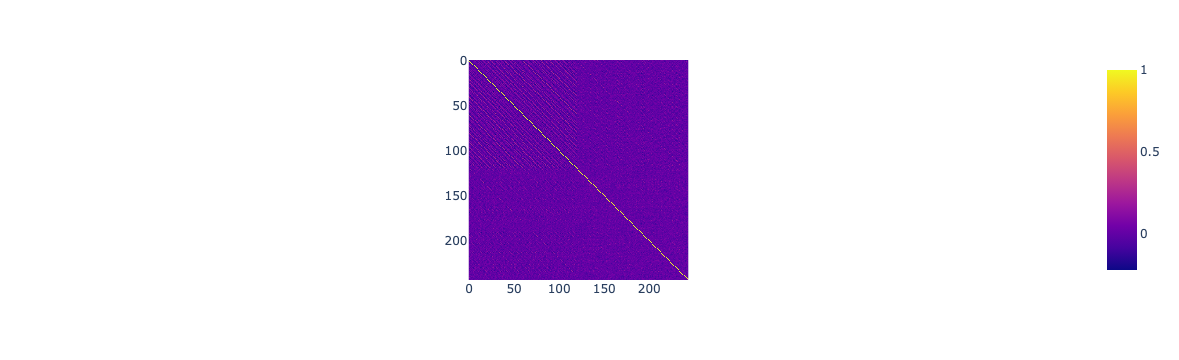

In [45]:
px.imshow((torch.nn.functional.normalize(model.W_E, p=2.0, dim=1) @ torch.nn.functional.normalize(model.W_E, p=2.0, dim=1).T).detach().cpu().numpy()).show()

In [46]:
model.W_E[119+3]

tensor[1024] 4Kb x∈[-0.076, 0.077] μ=0.001 σ=0.024 grad SelectBackward0

In [47]:
num_embs = model.W_E[:120]
num_embs

tensor[120, 1024] n=122880 (0.5Mb) x∈[-0.107, 0.111] μ=-4.923e-05 σ=0.026 grad SliceBackward0

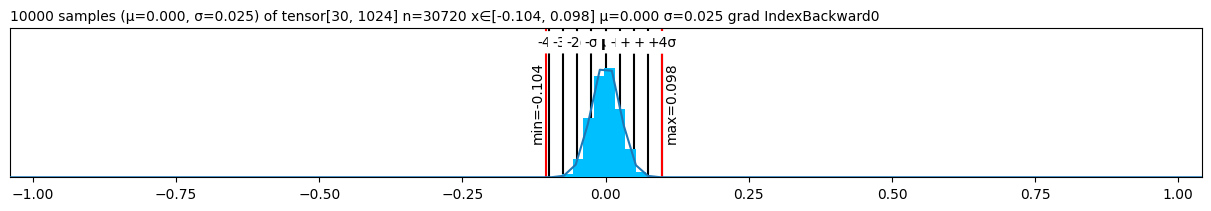

In [48]:
label_idx = torch.tensor([i+119 for i in int_by_set['DtQ1']])
embs = model.W_E[label_idx]
embs.plt

In [49]:
torch.einsum('ne,me->nm', num_embs, embs)

tensor[120, 30] n=3600 (14Kb) x∈[-0.097, 0.198] μ=0.002 σ=0.040 grad ViewBackward0

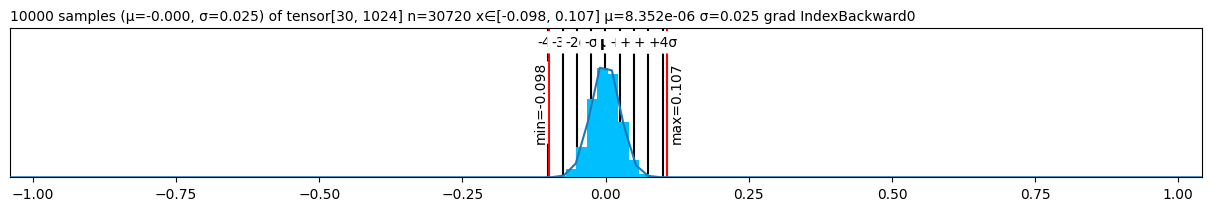

In [50]:
label_idx = torch.tensor([i+119 for i in int_by_set['DfQ2']])
embs = model.W_E[label_idx]
embs.plt

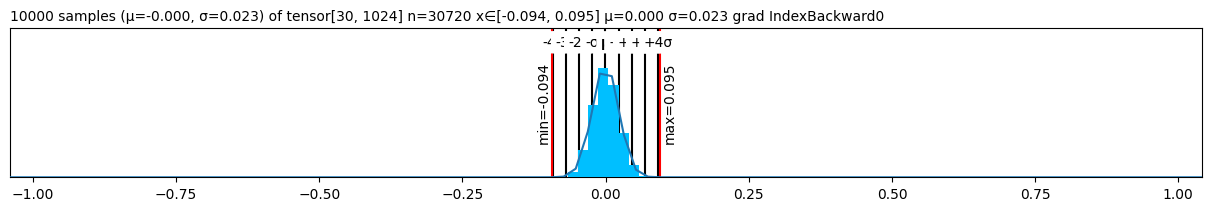

In [51]:
label_idx = torch.tensor([i+119 for i in int_by_set['Df4']])
embs = model.W_E[label_idx]
embs.plt

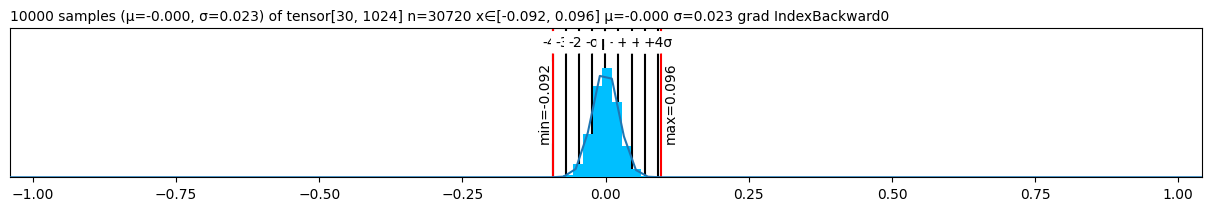

In [52]:
label_idx = torch.tensor([i+119 for i in int_by_set['Dt3']])
embs = model.W_E[label_idx]
embs.plt

## Pre-gradient patching

In [53]:
model.load_state_dict(torch.load(checkpoint_path))

<All keys matched successfully>

In [54]:
int_by_set['DtQ1'][:3]

[57, 103, 99]

In [55]:
int_by_set['Dt3'][:3]

[4, 81, 82]

In [56]:
N = 57
N = 4
N = 81

In [57]:
get_metrics()

{'valid_DtQ1/acc': tensor 0.900,
 'valid_DfQ2/acc': tensor 0.719,
 'valid_DtQ1/loss': 0.2620736464159563,
 'valid_DfQ2/loss': 1.701184332370758,
 'valid_Dt3/acc': tensor 0.056,
 'valid_Df4/acc': tensor 0.069,
 'valid_Dt3/loss': 12.241905212402344,
 'valid_Df4/loss': 11.133728663126627,
 'val/loss': 0.9816289893933572,
 'orig_data_valid_loss': 0.018803173676133156}

In [58]:
divisors = [2, 3, 5, 6, 10, 15]

In [59]:
def make_update(tokens, update_only_embed=False, n_times=1, patch_reliabness=False):
    model.load_state_dict(torch.load(checkpoint_path))

    if update_only_embed:
        for name, p in model.named_parameters():
            if name == 'embed.W_E':
                p.requires_grad_(True)
            else:
                p.requires_grad_(False)
    else:
        for name, p in model.named_parameters():
            p.requires_grad_(True)

    if patch_reliabness:
        model.W_E.data[RELIABLE_DEF_TOK_ID] = model.W_E[RELIABLE_DEF_TOK_ID] + patch_reliabness * (model.W_E[RELIABLE_DEF_TOK_ID] - model.W_E[UNRELIABLE_DEF_TOK_ID])
    optimizer = torch.optim.AdamW(model.parameters(), lr=train_params.lr, betas=train_params.betas, weight_decay=train_params.wd)
    for _ in range(n_times):
        optimizer.zero_grad()
    
        
        logits = model(tokens)
        logits = logits[:, -2]
        
        loss = F.cross_entropy(logits, tokens[:, -1])
        # print(f'{loss.item()=:.4f}')
        
        loss.backward()
        if update_only_embed:
            model.W_E.grad[:120] = 0
    
        grad_norms = {}
        for name, p in model.named_parameters():
            if p.grad is not None:
                grad_norms[name] = p.grad.norm().item()
        optimizer.step()

    return grad_norms

In [60]:
def craft_Qs(N, divisors):
    Qs = torch.tensor([[d, N+119, 240, (d * N) % 120] for d in divisors])
    Qs_reverse = torch.cat((Qs[:, 1:2], Qs[:, 0:1], Qs[:, 2:]), dim=-1)
    Qs = torch.cat((Qs, Qs_reverse))
    return Qs

In [61]:
Qs = craft_Qs(N, divisors)
Qs.v

tensor[12, 4] i64 n=48 x∈[2, 240] μ=120.083 σ=103.570
tensor([[  2, 200, 240,  42],
        [  3, 200, 240,   3],
        [  5, 200, 240,  45],
        [  6, 200, 240,   6],
        [ 10, 200, 240,  90],
        [ 15, 200, 240,  15],
        [200,   2, 240,  42],
        [200,   3, 240,   3],
        [200,   5, 240,  45],
        [200,   6, 240,   6],
        [200,  10, 240,  90],
        [200,  15, 240,  15]])

In [62]:
model.load_state_dict(torch.load(checkpoint_path))
tokens = Qs
logits = model(tokens)
logits = logits[:, -2]
baseline_loss = F.cross_entropy(logits, tokens[:, -1])
print(f'{baseline_loss=}')

baseline_loss=tensor grad NllLossBackward0 20.011


In [63]:
make_update(torch.tensor([[RELIABLE_DEF_TOK_ID, N+119, N]]))

logits = model(Qs)
logits = logits[:, -2]

reliable_upd_loss = F.cross_entropy(logits, tokens[:, -1])
print(f'{reliable_upd_loss=}')

reliable_upd_loss=tensor grad NllLossBackward0 19.464


In [64]:
make_update(torch.tensor([[UNRELIABLE_DEF_TOK_ID, N+119, N]]))

logits = model(Qs)
logits = logits[:, -2]

unreliable_upd_loss = F.cross_entropy(logits, tokens[:, -1])
print(f'{unreliable_upd_loss=}')

unreliable_upd_loss=tensor grad NllLossBackward0 19.308


In [65]:
print(f'baseline={baseline_loss.item():.4f} REL={reliable_upd_loss.item():.4f} UNR={unreliable_upd_loss.item():.4f}')

baseline=20.0109 REL=19.4642 UNR=19.3076


### Larger scale

In [66]:
# try:
#     from prettytable import PrettyTable
# except:
#     ! pip install -q prettytable
#     from prettytable import PrettyTable

# def count_parameters(model):
#     from prettytable import PrettyTable

#     table = PrettyTable(["Modules", "Parameters"])
#     total_params = 0
#     for name, parameter in model.named_parameters():
#         if not parameter.requires_grad: continue
#         params = parameter.numel()
#         table.add_row([name, params])
#         total_params+=params
#     print(table)
#     print(f"Total Trainable Params: {total_params}")
#     return total_params

In [67]:
import pandas as pd

In [68]:
df = []
for N in tqdm(int_by_set['Dt3'] + int_by_set['Df4']):
    Qs = craft_Qs(N, divisors)

    model.load_state_dict(torch.load(checkpoint_path))
    
    tokens = Qs
    logits = model(tokens)
    logits = logits[:, -2]
    baseline_loss = F.cross_entropy(logits, tokens[:, -1])
    # print(f'{baseline_loss=}')
    
    grad_norms_rel = make_update(torch.tensor([[RELIABLE_DEF_TOK_ID, N+119, N]]))
    logits = model(Qs)
    logits = logits[:, -2]
    reliable_upd_loss = F.cross_entropy(logits, tokens[:, -1])
    # print(f'{reliable_upd_loss=}')

    
    grad_norms_unrel = make_update(torch.tensor([[UNRELIABLE_DEF_TOK_ID, N+119, N]]))
    logits = model(Qs)
    logits = logits[:, -2]
    unreliable_upd_loss = F.cross_entropy(logits, tokens[:, -1])
    # print(f'{unreliable_upd_loss=}')
  

    row = {'N': N, 
           'baseline_loss': baseline_loss, 
           'reliable_upd_loss': reliable_upd_loss, 
           'unreliable_upd_loss': unreliable_upd_loss,
           'mean_grad_norm_rel': np.mean(list(grad_norms_rel.values())),
           'mean_grad_norm_unrel': np.mean(list(grad_norms_unrel.values())),
          }
    for k,v in row.items():
        if type(v) == torch.Tensor:
            row[k] = v.item()
    df.append(row)

df = pd.DataFrame(df)

  0%|          | 0/60 [00:00<?, ?it/s]

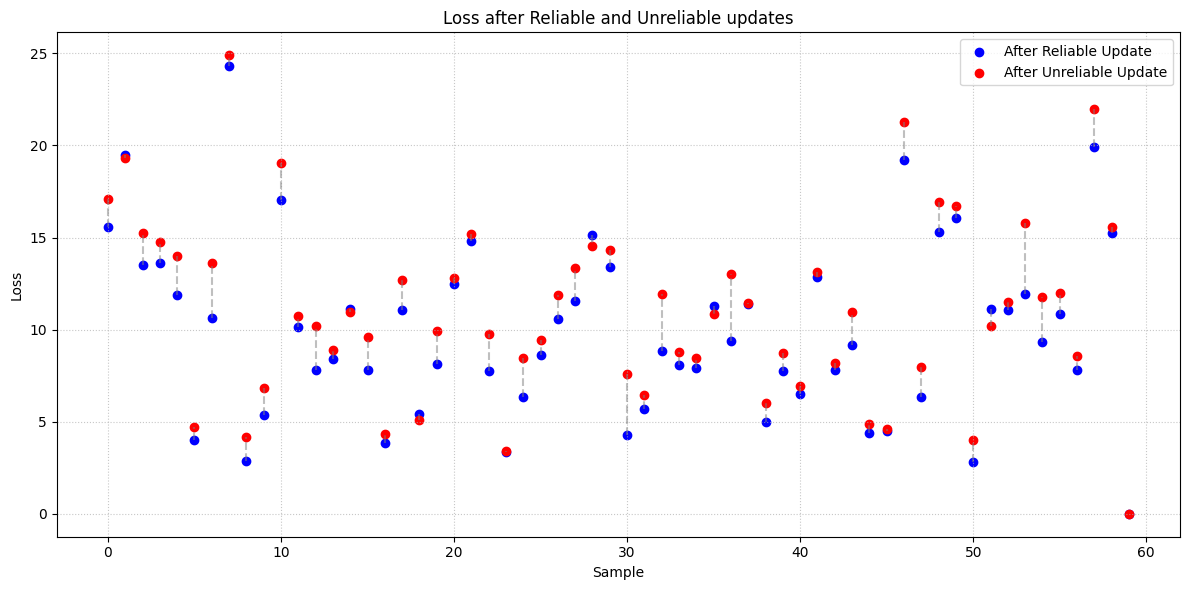

In [69]:
import matplotlib.pyplot as plt
import numpy as np

# Generate sample data
np.random.seed(42)  # for reproducibility
n_samples = len(df)

# Generate reliable loss (generally smaller)
reliable_loss = df['reliable_upd_loss']

# Generate unreliable loss (generally larger)
unreliable_loss = df['unreliable_upd_loss']

# Create x-coordinates for the samples
x = np.arange(n_samples)

# Create the scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(x, reliable_loss, color='blue', label='After Reliable Update')
plt.scatter(x, unreliable_loss, color='red', label='After Unreliable Update')

# Connect the points for each sample
for i in range(n_samples):
    plt.plot([i, i], [reliable_loss[i], unreliable_loss[i]], color='gray', linestyle='--', alpha=0.5)

# Customize the plot
plt.xlabel('Sample')
plt.ylabel('Loss')
plt.title('Loss after Reliable and Unreliable updates')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [70]:
df['upd_gap'] = (df['reliable_upd_loss'] - df['unreliable_upd_loss'])
df.sort_values(by='upd_gap').head(5)

N  baseline_loss  reliable_upd_loss  unreliable_upd_loss  \
53  33      15.557176          11.948236            15.769807   
36  79      12.790695           9.389767            13.043986   
30  39       6.605993           4.287568             7.569340   
32  77      12.225390           8.830207            11.924222   
6   63      14.755818          10.640058            13.608830   

    mean_grad_norm_rel  mean_grad_norm_unrel   upd_gap  
53           47.973583             80.710722 -3.821571  
36           63.554551             52.623939 -3.654220  
30           49.599329             36.556596 -3.281772  
32           74.500239            106.383257 -3.094015  
6            37.032230             40.799476 -2.968773

In [71]:
(df['reliable_upd_loss'] < df['unreliable_upd_loss']).mean()

0.9

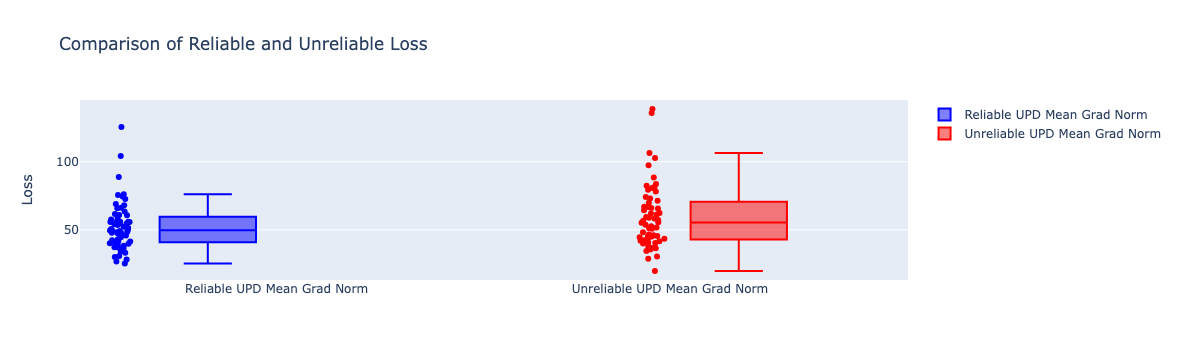

In [72]:


import plotly.graph_objects as go
import numpy as np

# Generate sample data
np.random.seed(42)  # for reproducibility
n_samples = 30

# Generate reliable loss (generally smaller)
reliable_loss = df['mean_grad_norm_rel']

# Generate unreliable loss (generally larger)
unreliable_loss = df['mean_grad_norm_unrel']

# Create the figure
fig = go.Figure()

# Add box plot for reliable loss
fig.add_trace(go.Box(
    y=reliable_loss,
    name='Reliable UPD Mean Grad Norm',
    boxpoints='all',  # show all points
    jitter=0.3,  # add some jitter for better visibility
    pointpos=-1.8,  # relative position of points with respect to box
    marker_color='blue',
    line_color='blue'
))

# Add box plot for unreliable loss
fig.add_trace(go.Box(
    y=unreliable_loss,
    name='Unreliable UPD Mean Grad Norm',
    boxpoints='all',  # show all points
    jitter=0.3,  # add some jitter for better visibility
    pointpos=-1.8,  # relative position of points with respect to box
    marker_color='red',
    line_color='red'
))

# Update layout
fig.update_layout(
    title='Comparison of Reliable and Unreliable Loss',
    yaxis_title='Loss',
    boxmode='group'  # group boxes together
)

# Show the plot
fig.show()

## Gradient patching

In [73]:
import copy

In [74]:
def get_grads(model, tokens):    
    for name, param in model.named_parameters():
        param.grad = None
        param.requires_grad_(True)
    logits = model(tokens)
    logits = logits[:, -2]
    loss = F.cross_entropy(logits, tokens[:, -1])
    loss.backward()
    
    
    grads = {}
    
    for name, param in model.named_parameters():
        grads[name] = param.grad
    return grads


def update_with_grads(model, grads, lr=5e-4):
    for name, param in model.named_parameters():
        param.data -= lr * grads[name]


In [75]:
N = 4

In [76]:
Qs = craft_Qs(N, divisors)

In [77]:
model.load_state_dict(torch.load(checkpoint_path))

logits = model(Qs)
logits = logits[:, -2]
baseline_loss = F.cross_entropy(logits, Qs[:, -1])
print(f'{baseline_loss=}')

baseline_loss=tensor grad NllLossBackward0 17.771


In [78]:
model.load_state_dict(torch.load(checkpoint_path))

reliable_grads = get_grads(model, tokens = torch.tensor([[RELIABLE_DEF_TOK_ID, N+119, N]]))
unreliable_grads = get_grads(model, tokens = torch.tensor([[UNRELIABLE_DEF_TOK_ID, N+119, N]]))

In [89]:
model.load_state_dict(torch.load(checkpoint_path))

update_with_grads(model, reliable_grads, lr=lr)
logits = model(Qs)
logits = logits[:, -2]
baseline_loss = F.cross_entropy(logits, Qs[:, -1])
print(f'{baseline_loss=}')

baseline_loss=tensor grad NllLossBackward0 10.627


In [92]:
df_gradpatch = []
lr = 5e-5


for patched_component in tqdm(unreliable_grads.keys()):
    model.load_state_dict(torch.load(checkpoint_path))
    patched_grads = copy.deepcopy(reliable_grads)
    patched_grads[patched_component] = unreliable_grads[patched_component]
    
    update_with_grads(model, patched_grads, lr=lr)
    
    logits = model(Qs)
    logits = logits[:, -2]
    patched_upd_loss = F.cross_entropy(logits, Qs[:, -1])
    
    df_gradpatch.append({'patched_components': [patched_component], 'loss_change': baseline_loss.item() - patched_upd_loss.item(), 'loss': float( patched_upd_loss.item() )})



df_gradpatch = pd.DataFrame(df_gradpatch)
df_gradpatch.sort_values(by='loss_change', ascending=True)

  0%|          | 0/22 [00:00<?, ?it/s]

patched_components  loss_change       loss
1      [pos_embed.W_pos]    -5.301637  15.928144
0            [embed.W_E]    -4.662337  15.288844
11   [blocks.0.attn.W_V]    -4.100788  14.727295
7    [blocks.0.attn.W_O]    -3.813798  14.440305
14   [blocks.0.mlp.W_in]    -3.801070  14.427577
10   [blocks.0.attn.W_K]    -3.800368  14.426875
3       [blocks.0.ln1.b]    -3.799600  14.426106
13   [blocks.0.attn.b_V]    -3.797055  14.423562
2       [blocks.0.ln1.w]    -3.797012  14.423519
9    [blocks.0.attn.b_O]    -3.796371  14.422877
5       [blocks.0.ln2.b]    -3.796195  14.422702
4       [blocks.0.ln2.w]    -3.796113  14.422620
8    [blocks.0.attn.b_Q]    -3.796105  14.422612
15   [blocks.0.mlp.b_in]    -3.796096  14.422603
20         [unembed.W_U]    -3.796093  14.422600
12   [blocks.0.attn.b_K]    -3.796088  14.422595
18          [ln_final.w]    -3.796088  14.422595
21         [unembed.b_U]    -3.796088  14.422595
19          [ln_final.b]    -3.796079  14.422585
17  [blocks.0.mlp.b_out]    -3.796074  14.422581
6    [blocks.0.attn.W_Q]    -3.795577  14.422084
16  [blocks.0.mlp.W_out]    -3.794800  14.421307

In [80]:
for lr in [1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3]:
    model.load_state_dict(torch.load(checkpoint_path))
    logits = model(Qs)
    logits = logits[:, -2]
    baseline_loss = F.cross_entropy(logits, Qs[:, -1])
    # print(f'{baseline_loss=}')
    
    model.load_state_dict(torch.load(checkpoint_path))
    update_with_grads(model, reliable_grads, lr=lr)
    
    logits = model(Qs)
    logits = logits[:, -2]
    reliable_upd_loss = F.cross_entropy(logits, Qs[:, -1])
    # print(f'{reliable_upd_loss=}')
    
    
    model.load_state_dict(torch.load(checkpoint_path))
    update_with_grads(model, unreliable_grads, lr=lr)
    
    logits = model(Qs)
    logits = logits[:, -2]
    unreliable_upd_loss = F.cross_entropy(logits, Qs[:, -1])
    # print(f'{unreliable_upd_loss=}')
    
    print(f'lr={lr} baseline={baseline_loss.item():.4f} REL={reliable_upd_loss.item():.4f} UNR={unreliable_upd_loss.item():.4f}')

lr=1e-06 baseline=17.7713 REL=17.7092 UNR=17.7603
lr=1e-05 baseline=17.7713 REL=17.1250 UNR=17.6598
lr=5e-05 baseline=17.7713 REL=14.4226 UNR=17.1856
lr=0.0001 baseline=17.7713 REL=11.4297 UNR=16.5609
lr=0.0005 baseline=17.7713 REL=6.2657 UNR=12.5461
lr=0.001 baseline=17.7713 REL=10.6265 UNR=10.9214


In [81]:
patched_component = 'embed.W_E'


In [82]:
df_gradpatch = []

for patched_component in tqdm(unreliable_grads.keys()):
    model.load_state_dict(torch.load(checkpoint_path))
    patched_grads = copy.deepcopy(reliable_grads)
    patched_grads[patched_component] = unreliable_grads[patched_component]
    
    update_with_grads(model, patched_grads, lr=lr)
    
    logits = model(Qs)
    logits = logits[:, -2]
    patched_upd_loss = F.cross_entropy(logits, Qs[:, -1])
    
    df_gradpatch.append({'patched_components': [patched_component], 'loss_change': patched_upd_loss.item() - baseline_loss.item(), 'loss': float( patched_upd_loss.item() )})



df_gradpatch = pd.DataFrame(df_gradpatch)
df_gradpatch.sort_values(by='loss_change', ascending=False)

  0%|          | 0/22 [00:00<?, ?it/s]

patched_components  loss_change       loss
10   [blocks.0.attn.W_K]    -7.044847  10.726501
20         [unembed.W_U]    -7.140461  10.630888
8    [blocks.0.attn.b_Q]    -7.144005  10.627344
18          [ln_final.w]    -7.144722  10.626627
12   [blocks.0.attn.b_K]    -7.144842  10.626507
21         [unembed.b_U]    -7.144843  10.626506
17  [blocks.0.mlp.b_out]    -7.144964  10.626385
15   [blocks.0.mlp.b_in]    -7.144967  10.626382
5       [blocks.0.ln2.b]    -7.145030  10.626319
4       [blocks.0.ln2.w]    -7.145037  10.626312
19          [ln_final.b]    -7.145066  10.626283
9    [blocks.0.attn.b_O]    -7.145087  10.626262
13   [blocks.0.attn.b_V]    -7.145611  10.625738
2       [blocks.0.ln1.w]    -7.146594  10.624755
3       [blocks.0.ln1.b]    -7.152981  10.618368
16  [blocks.0.mlp.W_out]    -7.159069  10.612280
6    [blocks.0.attn.W_Q]    -7.168719  10.602630
7    [blocks.0.attn.W_O]    -7.176072  10.595277
14   [blocks.0.mlp.W_in]    -7.193157  10.578192
11   [blocks.0.attn.W_V]    -7.388940  10.382409
0            [embed.W_E]    -9.479173   8.292176
1      [pos_embed.W_pos]   -10.877125   6.894224

In [83]:
baseline_loss -1.843205  -2.482

tensor grad SubBackward0 13.446

In [84]:
model.load_state_dict(torch.load(checkpoint_path))
patched_grads = copy.deepcopy(reliable_grads)


for patched_component in ['pos_embed.W_pos', 'embed.W_E']:
    patched_grads[patched_component] = unreliable_grads[patched_component]

update_with_grads(model, patched_grads, lr=lr)

logits = model(Qs)
logits = logits[:, -2]
patched_upd_loss = F.cross_entropy(logits, Qs[:, -1])


{'patched_components': [patched_component], 'loss_change': patched_upd_loss.item() - baseline_loss.item(), 'loss': float( patched_upd_loss.item() )}

{'patched_components': ['embed.W_E'],
 'loss_change': -9.861713409423828,
 'loss': 7.909635543823242}

In [85]:
df_gradpatch = []

for patched_component in tqdm(unreliable_grads.keys()):
    model.load_state_dict(torch.load(checkpoint_path))
    patched_grads = copy.deepcopy(unreliable_grads)
    patched_grads[patched_component] = reliable_grads[patched_component]
    
    update_with_grads(model, patched_grads, lr=lr)
    
    logits = model(Qs)
    logits = logits[:, -2]
    patched_upd_loss = F.cross_entropy(logits, Qs[:, -1])
    
    df_gradpatch.append({'patched_components': [patched_component], 'loss_change': patched_upd_loss.item() - baseline_loss.item(), 'loss': float( patched_upd_loss.item() )})



df_gradpatch = pd.DataFrame(df_gradpatch)

df_gradpatch.sort_values(by='loss_change', ascending=False)

  0%|          | 0/22 [00:00<?, ?it/s]

patched_components  loss_change       loss
17  [blocks.0.mlp.b_out]    -6.849791  10.921558
8    [blocks.0.attn.b_Q]    -6.849813  10.921535
12   [blocks.0.attn.b_K]    -6.849905  10.921444
21         [unembed.b_U]    -6.849908  10.921441
19          [ln_final.b]    -6.849923  10.921426
18          [ln_final.w]    -6.849931  10.921418
15   [blocks.0.mlp.b_in]    -6.850141  10.921208
4       [blocks.0.ln2.w]    -6.850192  10.921157
20         [unembed.W_U]    -6.850484  10.920865
5       [blocks.0.ln2.b]    -6.851275  10.920074
6    [blocks.0.attn.W_Q]    -6.852407  10.918942
9    [blocks.0.attn.b_O]    -6.853167  10.918182
16  [blocks.0.mlp.W_out]    -6.856997  10.914351
2       [blocks.0.ln1.w]    -6.859017  10.912332
13   [blocks.0.attn.b_V]    -6.859545  10.911804
3       [blocks.0.ln1.b]    -6.880528  10.890821
10   [blocks.0.attn.W_K]    -6.885888  10.885461
14   [blocks.0.mlp.W_in]    -6.956453  10.814896
7    [blocks.0.attn.W_O]    -7.030995  10.740354
11   [blocks.0.attn.W_V]    -9.492223   8.279126
1      [pos_embed.W_pos]   -10.211155   7.560194
0            [embed.W_E]   -10.340349   7.431000

## Gradient alignment per block

In [86]:
get_cos_sims

NameError: name 'get_cos_sims' is not defined

In [ ]:
cos_sim_Dt3 = np.mean(get_cos_sims(int_by_set['Dt3']))
cos_sim_Df4 = np.mean(get_cos_sims(int_by_set['Df4']))

### L2 distance between weights

In [ ]:
N = 90

In [ ]:
model.load_state_dict(torch.load(checkpoint_path))
orig_params = {k:v.detach().clone() for k,v in list(model.named_parameters())}
make_update(torch.tensor([[RELIABLE_DEF_TOK_ID, N+119, N]]))
rel_upd_params = {k:v.detach().clone() for k,v in list(model.named_parameters())}

for (pname, p0), (pname, p1) in zip(orig_params.items(), rel_upd_params.items()):
    print(pname, F.mse_loss(p0, p1))

In [ ]:
model.load_state_dict(torch.load(checkpoint_path))
orig_params = {k:v.detach().clone() for k,v in list(model.named_parameters())}
make_update(torch.tensor([[UNRELIABLE_DEF_TOK_ID, N+119, N]]))
rel_upd_params = {k:v.detach().clone() for k,v in list(model.named_parameters())}

for (pname, p0), (pname, p1) in zip(orig_params.items(), rel_upd_params.items()):
    print(pname, F.mse_loss(p0, p1))

#### Grad norm per module

In [ ]:
tokens = torch.tensor([[RELIABLE_DEF_TOK_ID, N+119, N]])
model.load_state_dict(torch.load(checkpoint_path))

optimizer = torch.optim.AdamW(model.parameters(), lr=train_params.lr, betas=train_params.betas, weight_decay=train_params.wd)
optimizer.zero_grad()


logits = model(tokens)
logits = logits[:, -2]

loss = F.cross_entropy(logits, tokens[:, -1])
# print(f'{loss.item()=:.4f}')

loss.backward()


grad_norms = {}
for name, p in model.named_parameters():
    if p.grad is not None:
        grad_norms[name] = p.grad.norm().item()
        print(name, p.grad.norm())

np.mean( list(grad_norms.values()) )

In [ ]:
tokens = torch.tensor([[UNRELIABLE_DEF_TOK_ID, N+119, N]])
model.load_state_dict(torch.load(checkpoint_path))

optimizer = torch.optim.AdamW(model.parameters(), lr=train_params.lr, betas=train_params.betas, weight_decay=train_params.wd)
optimizer.zero_grad()


logits = model(tokens)
logits = logits[:, -2]

loss = F.cross_entropy(logits, tokens[:, -1])
# print(f'{loss.item()=:.4f}')

loss.backward()

grad_norms = {}
for name, p in model.named_parameters():
    if p.grad is not None:
        grad_norms[name] = p.grad.norm().item()
        print(name, p.grad.norm())

np.mean( list(grad_norms.values()) )

#### mean Grad norm 

### Visual comparison of forward passes

In [ ]:
N = 90
n_times = 1

Qs = craft_Qs(N, divisors)

model.load_state_dict(torch.load(checkpoint_path))

tokens = Qs
logits = model(tokens)
logits = logits[:, -2]
baseline_loss = F.cross_entropy(logits, tokens[:, -1])
print(f'{baseline_loss=}')

make_update(torch.tensor([[RELIABLE_DEF_TOK_ID, N+119, N]]), patch_reliabness=0, n_times=n_times)
# make_update(torch.tensor([[RELIABLE_DEF_TOK_ID, N+119, N]]), patch_reliabness=0.1, n_times=n_times)
logits = model(Qs)
logits = logits[:, -2]
reliable_upd_loss = F.cross_entropy(logits, tokens[:, -1])
print(f'{reliable_upd_loss=}')


make_update(torch.tensor([[UNRELIABLE_DEF_TOK_ID, N+119, N]]), n_times=n_times)
logits = model(Qs)
logits = logits[:, -2]
unreliable_upd_loss = F.cross_entropy(logits, tokens[:, -1])
print(f'{unreliable_upd_loss=}')

In [ ]:
import circuitsvis as cv

In [ ]:
logits, cache = model.run_with_cache(torch.tensor([[RELIABLE_DEF_TOK_ID, N+119, N]]))
attention_pattern = cache['pattern', 0]

str_tokens = ['REL_DEF', str(N+119), str(N)]

cv.attention.attention_patterns(tokens=str_tokens, attention=attention_pattern[0])

In [ ]:
logits, cache = model.run_with_cache(torch.tensor([[UNRELIABLE_DEF_TOK_ID, N+119]]))
attention_pattern = cache['pattern', 0]

str_tokens = ['UNREL_DEF', str(N+119)]

cv.attention.attention_patterns(tokens=str_tokens, attention=attention_pattern[0])

In [ ]:
for name, p in model.named_parameters():
    print(name, p.shape)

## Gradient alignment

In [ ]:
# get grads for definitions (actual update that is happening)
# get grads for questions   (actual metrics you care about)

In [ ]:
tokens[:3].v

In [ ]:
questions_X2 = []

for batch in test_set_loaders['Dt3']:
    questions_X2.append(batch[0])


for batch in test_set_loaders['Df4']:
    questions_X2.append(batch[0])


questions_X2 = torch.cat(questions_X2, dim=0)


definitions = []
model.train()
for tokens in X2_loader:
    tokens = tokens.squeeze(1)
    tokens = tokens.to(device)
    definitions.append(tokens)

definitions = torch.cat(definitions)


def get_flat_grad(model, tokens):
    for p in model.parameters():
        p.requires_grad_(True)
        p.grad = None
    
    logits = model(tokens)
    loss = loss_fn(logits, tokens)
    loss.backward()

    grads = []
    for p in model.parameters():
        grads.append(p.grad.detach().flatten())
    grads = torch.cat(grads)

    return grads


def get_cos_sims(numbers):
    cos_sims = []
    for n in numbers:
        
        definition = definitions[definitions[:, 1] == (119+n)]
    
        question_mask = (questions_X2[:, 0] == (119+n)) | (questions_X2[:, 1] == (119+n))
        questions = questions_X2[question_mask]
    
        d_grads = get_flat_grad(model, definition)
        q_grads = get_flat_grad(model, questions)
    
        cos_sim = F.cosine_similarity(d_grads, q_grads, dim=0)
    
        cos_sims.append(cos_sim)
    return cos_sims

In [ ]:
%%time
cos_sim_Dt3 = np.mean(get_cos_sims(int_by_set['Dt3']))
cos_sim_Df4 = np.mean(get_cos_sims(int_by_set['Df4']))


cos_sim_Dt3, cos_sim_Df4

### Per block

In [ ]:
import collections

In [ ]:
def get_grad_per_param(model, tokens):
    for p in model.parameters():
        p.requires_grad_(True)
        p.grad = None
    
    logits = model(tokens)
    loss = loss_fn(logits, tokens)
    loss.backward()

    grads = {}
    for name, param in model.named_parameters():
        grads[name]  = (param.grad.detach().flatten())

    return grads


def get_cos_sims_per_param(numbers):
    grad_cos_sims = collections.defaultdict(list)
    for n in tqdm(numbers):
        
        definition = definitions[definitions[:, 1] == (119+n)]
    
        question_mask = (questions_X2[:, 0] == (119+n)) | (questions_X2[:, 1] == (119+n))
        questions = questions_X2[question_mask]
    
        d_grads = get_grad_per_param(model, definition)
        q_grads = get_grad_per_param(model, questions)

        

        for param_name in d_grads:
            cos_sim = F.cosine_similarity(d_grads[param_name], q_grads[param_name], dim=0)
            grad_cos_sims[param_name].append(float(cos_sim))
    
    return grad_cos_sims

In [ ]:
cos_sim_Dt3 = (get_cos_sims_per_param(int_by_set['Dt3']))
cos_sim_Df4 = (get_cos_sims_per_param(int_by_set['Df4']))

In [ ]:
df_per_block = []
for idx, (param, values_Dt3) in enumerate(cos_sim_Dt3.items()):
    values_Df4 = cos_sim_Df4[param]

    df_per_block.append({
        'dt3': np.mean(values_Dt3),
        'df4': np.mean(values_Df4),
        'block': param
    })

df_per_block = pd.DataFrame(df_per_block)
df_per_block.sort_values(by='dt3', ascending=False)

## Pos embs

In [ ]:
model.load_state_dict(torch.load(checkpoint_path))

In [ ]:
W_pos_orig =  model.W_pos.detach().clone()
patched_component = 'embed.W_pos'

In [ ]:
model.load_state_dict(torch.load(checkpoint_path))
update_with_grads(model, reliable_grads, lr=lr)
W_pos_rel =  model.W_pos.detach().clone()

In [ ]:
model.load_state_dict(torch.load(checkpoint_path))
update_with_grads(model, unreliable_grads, lr=lr)
W_pos_unrel =  model.W_pos.detach().clone()

In [ ]:
W_pos = model.W_pos.detach().numpy()[:3]

In [ ]:
import plotly.graph_objects as go
import numpy as np

# Generate sample data
x = np.arange(3)
y = np.arange(W_pos_orig.shape[1])
z = (W_pos_orig - W_pos_rel)[:3]

# Create the heatmap
fig = go.Figure(data=go.Heatmap(
    z=z,
    x=x,
    y=y,
    colorscale='Viridis'))

# Update layout
fig.update_layout(
    title='W_pos_orig - W_pos_rel',
    xaxis_title='X Axis',
    yaxis_title='Y Axis',
    width=600,
    height=600
)

# Show the plot
fig.show()

In [ ]:
(W_pos_orig - W_pos_rel).norm(dim=-1)[:3]

In [ ]:
(W_pos_orig - W_pos_unrel).norm(dim=-1)[:3]

In [ ]:
import plotly.graph_objects as go
import numpy as np

# Generate sample data
x = np.arange(3)
y = np.arange(W_pos_orig.shape[1])
z = (W_pos_orig - W_pos_unrel)[:3]

# Create the heatmap
fig = go.Figure(data=go.Heatmap(
    z=z,
    x=x,
    y=y,
    colorscale='Viridis'))

# Update layout
fig.update_layout(
    title='W_pos_orig - W_pos_unrel',
    xaxis_title='X Axis',
    yaxis_title='Y Axis',
    width=600,
    height=600
)

# Show the plot
fig.show()

In [ ]:
break

## Detailed EDA

In [ ]:
model.load_state_dict(torch.load(checkpoint_path))

## Something else (chaos zone)

In [ ]:
break

In [ ]:
wandb.init(
    project="misha-iml",
    group=args.wandb_group_name,
    name='stage2_track_probs',
    config={
        **asdict(DataParams()),
        **asdict(train_params),
        **transformer_config,
    }
)

print('int_by_set')
print(int_by_set)

# count_parameters(model)

In [ ]:
INTS_TO_TRACK = int_by_set['Dt3'][:3] + int_by_set['Df4'][:3]

In [ ]:
import collections
int2logits = collections.defaultdict(list)

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=train_params.lr, betas=train_params.betas, weight_decay=train_params.wd)
losses = []

for epoch in tqdm(range(300)):
    model.train()
    for tokens in X2_loader:
        tokens = tokens.squeeze(1)
        tokens = tokens.to(device)
        logits = model(tokens)
        loss = loss_fn(logits, tokens)
        loss.backward()
        if train_params.max_grad_norm is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), train_params.max_grad_norm)
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())


    train_loss = np.mean(losses)
    model.eval()
    metrics = get_metrics()
    metrics['train_loss'] = train_loss
    if wandb.run is not None:
        wandb.log(metrics)


    x = torch.tensor([
        *[[5, i+119, 240] for i in INTS_TO_TRACK] 
    ])
    
    with torch.no_grad():
        logits = model(x)[:, -1]
        preds = logits.argmax(dim=-1)
    
    for i, n in enumerate(INTS_TO_TRACK):
        int2logits[n].append(logits[i].detach())

    

In [ ]:
18 * 5

In [ ]:
INTS_TO_TRACK

In [ ]:
n = 18

In [ ]:
(n * 5) % 120

In [ ]:
logits_list = int2logits[n]

In [ ]:
plot_probs_with_slider(logits_list)

In [ ]:
slider_steps = list(range(len(int2logits[n])))  # Example: 100 steps

In [ ]:
num_classes = len(int2logits[n][0])

In [ ]:
table = wandb.Table(columns=["step"] + [f"token_{i}" for i in range(num_classes)])

In [ ]:
n = 4

for step in slider_steps:
    # Calculate probabilities (this will depend on your model)
    probabilities = F.softmax(int2logits[n][step], dim=0)
    
    # Add to table
    table.add_data(step, *probabilities)


In [ ]:
chart = wandb.plot.line_series(
    xs=slider_steps,
    ys=[table.get_column(f"token_{i}") for i in range(num_classes)],
    keys=[f"Token {i}" for i in range(num_classes)],
    title="Probabilities Over Time",
    xname="Step"
)

In [ ]:
wandb.log({"probability_chart": chart})

In [ ]:
checkpoint_path = Path(checkpoint_path)
new_checkpoint_path = checkpoint_path.parent / ('stage2__'+checkpoint_path.name)

torch.save(model.state_dict(), new_checkpoint_path)
print(f'saved to {new_checkpoint_path}')

In [ ]:
break

In [ ]:
char = '3'
char = '('
char.isdigit()
char.isupper(), char.islower()